In [1]:
%matplotlib inline
import PIL
import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from skimage.filters import gabor
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops

# Downloading dataset

In [2]:
trainDset =  datasets.CIFAR10('./cifar10/', train=True, download=True) 
testDset =  datasets.CIFAR10('./cifar10/', train=False, download=True)

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
Files already downloaded and verified


In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainDset)))
print('No. of samples in test set: '+str(len(testDset)))

No. of samples in train set: 50000
No. of samples in test set: 10000


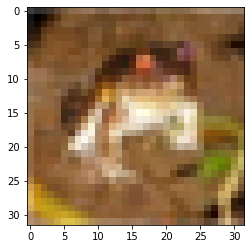

In [4]:
# Feature extraction on single image
img = trainDset[0][0] #PIL image
img_gray = img.convert('L') #Converting to grayscale
img_arr = np.array(img_gray) #Converting to array
plt.imshow(img)

# LBP

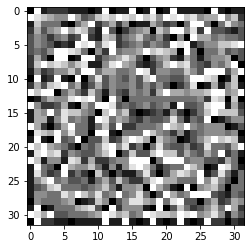

In [5]:
# Finding LBP
feat_lbp = local_binary_pattern(img_arr,8,1,'uniform') #Radius = 1, No. of neighbours = 8
feat_lbp = np.uint8((feat_lbp/feat_lbp.max())*255) #Converting to unit8
lbp_img = PIL.Image.fromarray(feat_lbp) #Conversion from array to PIL image
plt.imshow(lbp_img,cmap='gray') #Displaying LBP

In [6]:
# Energy and Entropy of LBP feature
lbp_hist,_ = np.histogram(feat_lbp,8)
lbp_hist = np.array(lbp_hist,dtype=float)
lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
lbp_energy = np.sum(lbp_prob**2)
lbp_entropy = -np.sum(np.multiply(lbp_prob,np.log2(lbp_prob)))
print('LBP energy = '+str(lbp_energy))
print('LBP entropy = '+str(lbp_entropy))# Energy and Entropy of LBP feature
lbp_hist,_ = np.histogram(feat_lbp,8)
lbp_hist = np.array(lbp_hist,dtype=float)
lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
lbp_energy = np.sum(lbp_prob**2)
lbp_entropy = -np.sum(np.multiply(lbp_prob,np.log2(lbp_prob)))
print('LBP energy = '+str(lbp_energy))
print('LBP entropy = '+str(lbp_entropy))

LBP energy = 0.14321517944335938
LBP entropy = 2.8958499002961196
LBP energy = 0.14321517944335938
LBP entropy = 2.8958499002961196


# Co - Occurance Matrix

In [7]:
# Finding GLCM features from co-occurance matrix
gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
homogeneity = greycoprops(gCoMat, prop='homogeneity')
energy = greycoprops(gCoMat, prop='energy')
correlation = greycoprops(gCoMat, prop='correlation')
print('Contrast = '+str(contrast[0][0]))
print('Dissimilarity = '+str(dissimilarity[0][0]))
print('Homogeneity = '+str(homogeneity[0][0]))
print('Energy = '+str(energy[0][0]))
print('Correlation = '+str(correlation[0][0]))

Contrast = 1296.0104166666665
Dissimilarity = 24.224999999999998
Homogeneity = 0.0626337793073455
Energy = 0.02654717695286387
Correlation = 0.6126460425663798


# Gabor Filter

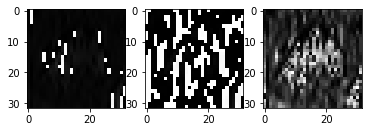

In [8]:
# Gabor filter
gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
# Displaying the filter response
fig, ax = plt.subplots(1,3)    
ax[0].imshow(gaborFilt_real,cmap='gray')
ax[1].imshow(gaborFilt_imag,cmap='gray')
ax[2].imshow(gaborFilt,cmap='gray')

In [9]:
# Energy and Entropy of Gabor filter response
gabor_hist,_ = np.histogram(gaborFilt,8)
gabor_hist = np.array(gabor_hist,dtype=float)
gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
gabor_energy = np.sum(gabor_prob**2)
gabor_entropy = -np.sum(np.multiply(gabor_prob,np.log2(gabor_prob)))
print('Gabor energy = '+str(gabor_energy))
print('Gabor entropy = '+str(gabor_entropy))

Gabor energy = 0.2469921112060547
Gabor entropy = 2.357696484594805


# Extracting features from all images in the dataset

In [10]:
# Generating training data by extracting features from all images
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(trainDset),featLength)) #Feature vector of each image is of size 1x1030
for tr in tqdm.tqdm_notebook(range(len(trainDset))):

    img = trainDset[tr][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))   
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[tr,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(trainDset[tr][1])
trainLabel = np.array(label) #Conversion from list to array

C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


In [11]:
# Generating testing data by extracting features from all images
label = []
testFeats = np.zeros((len(testDset),featLength)) #Feature vector of each image is of size 1x1030
for ts in tqdm.tqdm_notebook(range(len(testDset))):
    
    img = testDset[ts][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)    
    testFeats[ts,:] = concat_feat  #Stacking features vectors for each image
    # Class label
    label.append(testDset[ts][1])
testLabel = np.array(label)

C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2
C:\Users\Deepesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


# Feature normalization

In [12]:
# Normalizing the train features to the range [0,1]
trMaxs = np.amax(trainFeats,axis=0) #Finding maximum along each column
trMins = np.amin(trainFeats,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(50000,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(50000,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(trainFeats-trMins_rep,trMaxs_rep) #Element-wise division
# Normalizing the test features
tsMaxs_rep = np.tile(trMaxs,(10000,1)) #Repeating the maximum value along the rows
tsMins_rep = np.tile(trMins,(10000,1)) #Repeating the maximum value along the rows
testFeatsNorm = np.divide(testFeats-tsMins_rep,tsMaxs_rep) #Element-wise division

# Saving feature matrices to disk

In [13]:
# Saving normalized training data and labels
with open("trainFeats.pckl", "wb") as f:
    pickle.dump(trainFeatsNorm, f)
with open("trainLabel.pckl", "wb") as f:
    pickle.dump(trainLabel, f)
    
# Saving normalized testing data and labels
with open("testFeats.pckl", "wb") as f:
    pickle.dump(testFeatsNorm, f)
with open("testLabel.pckl", "wb") as f:
    pickle.dump(testLabel, f)
    
print('Files saved to disk!')

Files saved to disk!
